# Maximum Likelihood and Applications in Astronomy, part 2

A. Connolly, M. Juric & Z. Ivezic 2018

## Example 1: Fitting a Line using a Maximum Likelihood Estimator


Assume the scatter in our measurements (the residuals) is generated by a gaussian process. I.e.:

>$ y_i = a x_i + b + r_i $

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the error the measurement induces.

Let us compute the likelihood. First, we ask ourselves what is the probability $p(y_i|x_i, M(a, b), \sigma)$ that a particular point $y_i$ would be measured. It is just the normal distribution:

>$ p(y_i|x_i, M(a, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right) $.

Given our previous definitions we can write down the $\ln L$

>$ \ln L(a, b) = constant - \frac{1}{2 \sigma^2} \sum_{i=1}^N (y_i - M(x_i))^2 $

This is the expression that we now minimize with respect to $a$ and $b$ to find ML estimators for those parameters. This is equivalent to minimizing the sum of the squares or a _least-squares method_

This astroML function adjusts matplotlib settings for a uniform feel in the 
textbook. Note that with `usetex=True`, fonts are rendered with $\LaTeX$. This 
may result in an error if $\LaTeX$ is not installed on your system.  In that 
case, you can set usetex to `False`.

In [1]:
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=15, usetex=True)

## MLE with outliers

Let's apply the MLE to data with uncertainties where these uncertainties include outliers. To keep this general we will use the scipy optimization function _optimize.fmin_ where we pass a function to be optimized and an initial guess (rather than a standard regression package)

Optimization terminated successfully.
         Current function value: 18.680770
         Iterations: 53
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: 289.963723
         Iterations: 70
         Function evaluations: 133


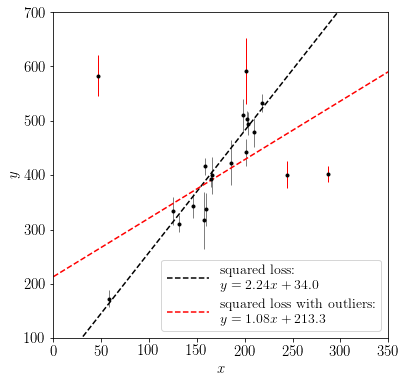

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

from scipy import optimize
from astroML.datasets import fetch_hogg2010test

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

# Define the standard squared-loss function
def squared_loss(m, b, x, y, dy):
    y_fit = m * x + b
    return np.sum(((y - y_fit) / dy) ** 2, -1)

# define a lambda function that defines the sum of squared errors

# initially exclude the outliers
f_squared = lambda beta: squared_loss(beta[0], beta[1], x=x[4:], y=y[4:], dy=dy[4:])

#include the outliers
f_squared_outlier = lambda beta_outlier: squared_loss(beta_outlier[0], beta_outlier[1], x=x, y=y, dy=dy)


#------------------------------------------------------------
# compute the maximum likelihood 
beta0 = (1, 30)
beta_squared = optimize.fmin(f_squared, beta0)

beta_squared_outlier = optimize.fmin(f_squared_outlier, beta0)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

x_fit = np.linspace(0, 350, 10)
ax.plot(x_fit, beta_squared[0] * x_fit + beta_squared[1], '--k',
        label="squared loss:\n $y=%.2fx + %.1f$" % tuple(beta_squared))

ax.plot(x_fit, beta_squared_outlier[0] * x_fit + beta_squared_outlier[1], '--k', color='red',
        label="squared loss with outliers:\n $y=%.2fx + %.1f$" % tuple(beta_squared_outlier))
ax.legend(loc=4, prop=dict(size=14))

ax.errorbar(x[4:], y[4:], dy[4:], fmt='.k', lw=1, ecolor='gray')
ax.errorbar(x[:4], y[:4], dy[:4], fmt='.k', lw=1, ecolor='red')


ax.set_xlim(0, 350)
ax.set_ylim(100, 700)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.show()

## How do we deal with outliers: modifying the likelihood

The $L_2$ ($\sum_{i=1}^N (y_i - M(x_i))^2$) norm is sensitive to outliers (i.e. it squares the residuals). A number of approaches exist for correcting for outliers. These include "sigma-clipping", using interquartile ranges, taking the median of solutions of subsets of the data, and least trimmed squares (which searchs for the subset of points that minimizes $\sum_i^K (y_i - \theta_ix_i)^2$).

We can also change the **loss function** or **likelihood** to reduce the weight of outliers. This is known as the _Huber loss function_

> $
\sum_{i=1}^N e(y_i|y),
$

where

>$
e(t) = \left\{
\begin{array}{ll}
\frac{1}{2} t^2 & \mbox{if} \; |t| \leq c, \\
c|t| - \frac{1}{2} c^2 & \mbox{if} \; |t| \geq c,
\end{array}
\right )
$

this is continuous and differentiable and transitions to an $L_1$ norm ($\sum_{i=1}^N |y_i - M(x_i)|$) for large excursions

![title](https://upload.wikimedia.org/wikipedia/commons/c/cc/Huber_loss.svg)



## Exercise 1: Create a likelihood function that reproduces the Huber Loss function and apply it to the data with outliers

Modify the _squared\_loss_ to transition from an L2-norm to and L1-norm

Optimization terminated successfully.
         Current function value: 18.680770
         Iterations: 48
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: 289.963723
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 43.439758
         Iterations: 59
         Function evaluations: 115


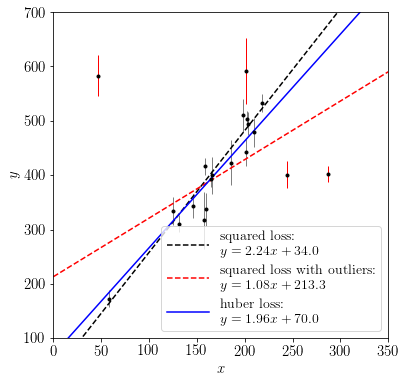

In [5]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

from scipy import optimize
from astroML.datasets import fetch_hogg2010test

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']


# Define the standard squared-loss function
def squared_loss(m, b, x, y, dy):
    y_fit = m * x + b
    return np.sum(((y - y_fit) / dy) ** 2, -1)

# Define the huber loss function
def huber_loss(m, b, x=0., y=0., dy=0., c=1):
    y_fit = m * x + b
    t = (y - y_fit)/dy
    et = np.zeros(np.size(t))
    et[np.abs(t)<=c] = 0.5 * t[np.abs(t)<=c]**2
    et[np.abs(t)>=c] = c*np.abs(t[np.abs(t)>=c]) - 0.5 * c**2
    return(np.sum(et))
    

# Define the log-likelihood via the Huber loss function

f_squared = lambda beta: squared_loss(beta[0], beta[1], x=x[4:], y=y[4:], dy=dy[4:])

f_squared_outlier = lambda beta: squared_loss(beta[0], beta[1], x=x, y=y, dy=dy)

f_huber = lambda beta: huber_loss(beta[0], beta[1], x=x, y=y, dy=dy, c=1)

#------------------------------------------------------------
# compute the maximum likelihood using the huber loss
beta0 = (2, 30)
beta_squared = optimize.fmin(f_squared, beta0)
beta_squared_outlier = optimize.fmin(f_squared_outlier, beta0)

beta_huber = optimize.fmin(f_huber, beta0)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

x_fit = np.linspace(0, 350, 10)
ax.plot(x_fit, beta_squared[0] * x_fit + beta_squared[1], '--k',
        label="squared loss:\n $y=%.2fx + %.1f$" % tuple(beta_squared))
ax.plot(x_fit, beta_squared_outlier[0] * x_fit + beta_squared_outlier[1], '--k', color='red',
        label="squared loss with outliers:\n $y=%.2fx + %.1f$" % tuple(beta_squared_outlier))
ax.plot(x_fit, beta_huber[0] * x_fit + beta_huber[1], '-k', color='blue',
        label="huber loss:\n $y=%.2fx + %.1f$" % tuple(beta_huber))
ax.legend(loc=4, prop=dict(size=14))

ax.errorbar(x[4:], y[4:], dy[4:], fmt='.k', lw=1, ecolor='gray')
ax.errorbar(x[:4], y[:4], dy[:4], fmt='.k', lw=1, ecolor='red')


ax.set_xlim(0, 350)
ax.set_ylim(100, 700)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.show()

## Example 2: Optimal Photometry

We now turn to examples of applications of ML in astronomy. We'll look at two cases: simple photometry and simultaneous fitting of galaxy size and total flux.

### Some useful definitions and functions

In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt
from astroML.plotting.mcmc import convert_to_stdev

In [7]:
def plotCutout(img, title = None, clabel='$counts$', xlabel='x (pixels)', ylabel='y (pixels)', loc=None, fig=None):
    """Make a nice looking plot of a small image"""
    if loc is None:
        fig, ax = plt.subplots(figsize=(8,8))
        fig.subplots_adjust(right=0.8, bottom=0.34)
    else:
        ax = fig.add_subplot(loc)

    # coordinate of the edge (assuming a square image)
    xe = img.shape[0] / 2.

    if title is None:
        title = "min = %.0f, max=%.0f" % (img.min(), img.max())
    
    ax.set_title(title, fontsize=14)
    plt.imshow(img, origin='lower', interpolation='nearest',
           extent=(-xe, xe, -xe, xe),
           cmap=plt.cm.binary, aspect=1)
    plt.clim(-20, 100)
    plt.colorbar().set_label(clabel)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

## A star and a point spread function

The **Point Spread Function** (the "PSF") is comprised of various contributions: from minute misalignments in the optics, to jitter in the tracking, to diffraction from the spider, to diffusion of the electrons as they travel through the silicon in the CCD ("charge diffusion"), to the homogenization of the PSF due to the refraction and diffraction in the atmosphere.  

The dominant effect is the one ***from the atmosphere***.

![PSF Formation](figures/psf-formation.jpg)

In practice, we don't construct the PSF from *ab initio* considerations (though there are plans in the LSST data management do so (**why?**)). Instead, we measure it by looking at the observed shape of bright, isolated, point sources (i.e., stars). Those observations are noisy, so we fit analytical profiles to estimate the true PSF.

Which profiles to fit? A good description of the point spread function is the Moffat profile:

>$ I = I_0 \left[ 1 + \left( \frac{r}{\alpha} \right)^2 \right]^{-\beta} $

where $r$ is the radius from the center of the object, $\alpha$ sets the overall size of the PSF spot, and $\beta$ controls the shape. This profile can be mathematically tedious to work with, so frequently a sum of Gaussians is used.

For simplicity, we will use just a single Gaussian here.

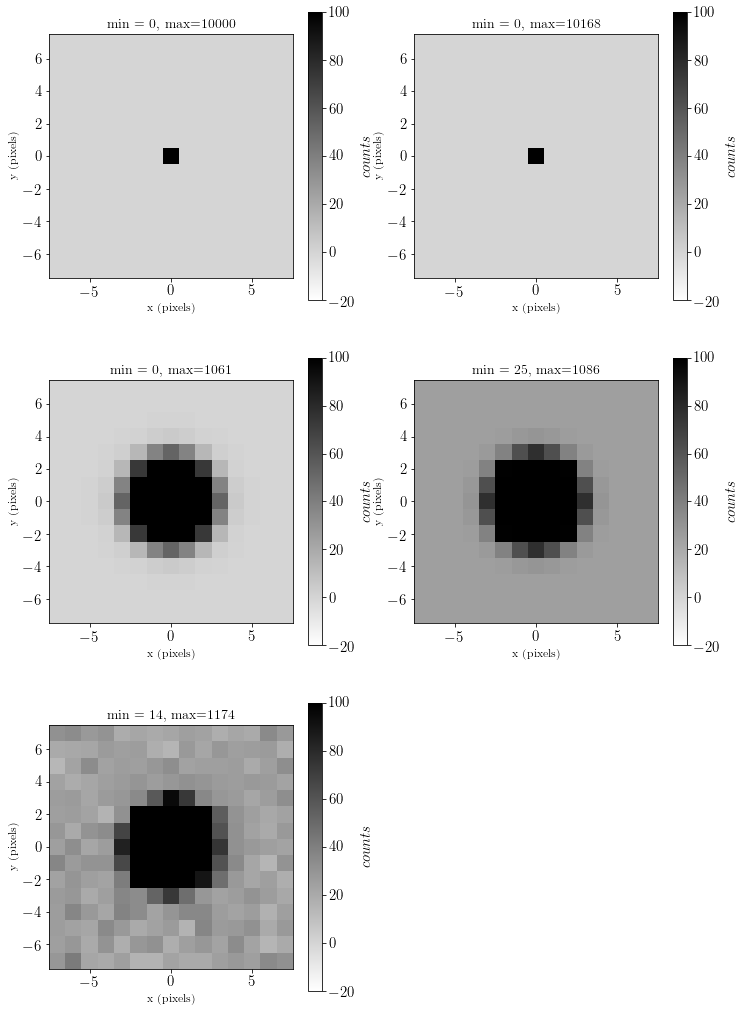

In [8]:
import math

Atrue = 10000.0    # the source count normalization
xdim = 15         # width of the image
ydim = 15         # height of the image
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid 
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
skyBg = 25        # sky background


def makePSF(shape, x0, y0, sigmaPSF):
    # Add a (Gaussian) PSF of width sigmaPSF, centered on (x0, y0)
    xx = np.arange(shape[0]) - shape[0]/2.+0.5
    yy = np.arange(shape[1]) - shape[1]/2.+0.5
    
    r = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    psf = np.exp(-r**2./2./sigmaPSF) / (2*math.pi*sigmaPSF)
    return psf

fig = plt.figure(figsize=(12,18))

# uniform flux
image = np.zeros((xdim, ydim))
image[7,7] = Atrue
plotCutout(image, loc=321, fig=fig)

# random Poisson process
image = np.zeros((xdim, ydim))
image[7,7] = np.random.poisson(Atrue)
plotCutout(image, loc=322, fig=fig)

# PSF 
image = np.zeros((xdim, ydim))
image = Atrue * makePSF(image.shape, 0, 0, sigmaPSF)
plotCutout(image, loc=323, fig=fig)

# PSF with background
image += skyBg
plotCutout(image, loc=324, fig=fig)

# PSF with background and noise
image = np.random.poisson(image)
plotCutout(image, loc=325, fig=fig)

simulatedImage = image



## Photometry (measuring the flux)

We now have an image that we observe, and some ***understanding of the processes that created it***. The latter is crucial as we will eventually construct a ***model*** of this process for the ML estimate.

Now we wish to estimate the flux. How should we do that? We will assume we have an estimate of the sky background

## Aperture Photometry

Before coming up with a more advanced technique, we'll try something simple to estimate the flux.

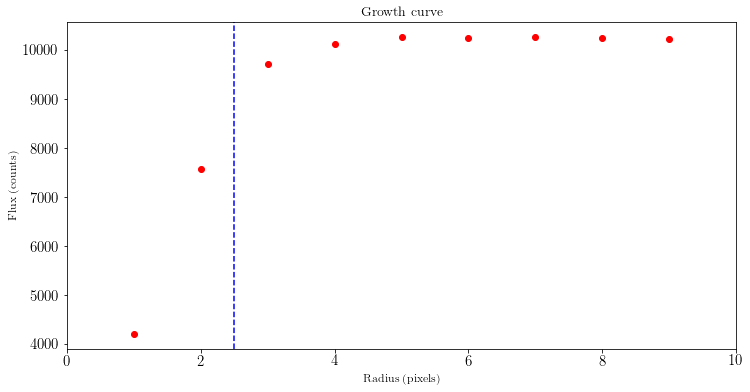

In [11]:
# Aperture photometry

def apPhot(image, r = 3, x0=0, y0=0):
    '''Integrate image given a circular aperture radius r'''
    xx = np.arange(image.shape[0]) - image.shape[0]/2.+0.5
    yy = np.arange(image.shape[1]) - image.shape[1]/2.+0.5
    
    rpix = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    apPhotImage = image[:]
    apPhotImage[rpix > r] = 0

    return apPhotImage.sum(), apPhotImage

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

aperture_radius = np.arange(1,10)
for r in aperture_radius:
    image = simulatedImage - skyBg
    count, apPhotImage = apPhot(image, r=r)
    #print ('A_ap(r=%.0f) = %.1f' % (r, count))
    plt.plot(r, count, 'ro')
plt.axvline(x=2.5, color='blue', ls='dashed')
ax.set_xlim(0,10)
ax.set_title('Growth curve', fontsize=14)
ax.set_xlabel('Radius (pixels)', fontsize=12)
ax.set_ylabel('Flux (counts)', fontsize=12)


## (Uncalibrated/Uncorrected) Aperture Photometry would introduce bias

This is a biased estimator. The result will asymptote to a value lower than the true value (there's flux we miss in the outskirts of the object).

In real-life usage, we would calibrate this out by performing *aperture correction*, or consistently using the same aperture for both calibration stars and stars of interest (under the assumption that the PSF is constant!).

## PSF Photometry: A Maximum Likelihood estimation of the flux

So our **model** for the image is that it consists of a Gaussian with a flux normalization fo $A$ , plus the background (which we've removed), plus the Gaussian noise (caused by photon quantization).

So, <u>once the background is removed</u>, for ***each pixel*** I can write:

>$ I(x,y) = A * PSF(x - x_0, y - y_0) + r_i $

where $r_i$ is drawn from a Gaussian with

>$N(0, \sigma_{x,y} = \sqrt{I_{x,y} + B})$

and $B$ is the sky background. It's critical not to forget the background when computing the sigma -- for faint sources, this is where most of the measurement uncertainty comes from!

## Exercise 2: Write down the likelihood and the log of the likelihood for fitting the model to the star

You can assume that the sky background has been subtracted and that the centroid of the star is known. The Likelihood **per pixel** is

> $L = \frac{1}{\sqrt{2 \pi \sigma}} A \exp{\left[- \frac{\left(I(x_i,y_i) - A\  \mathrm{PSF}(x_0,y_0)\right)^2}{2 \sigma^2} \right]} $

so the net likelihood is

> $\prod_{x,y}{L}$

or

> $\sum_{x,y}{\ln{L}}$

## Maximum Likelihood estimation of the flux

Note this is practically identical to our case with fitting a line, except that instead of having one index $i$, we have two indices for the data points, $(x, y)$. And ***each pixel*** is an independent data point that constrains our model.

So we can readily write out the log-likelihood as:

> $\ln{L} = constant - \sum_{i=1}^N \frac{\left(I(x_i,y_i) - A\  \mathrm{PSF}(x_0,y_0)\right)^2}{2 \sigma^2}$

The best way to think of this expression is as:

> 

where $data$, $model$, and $variance$ are implicitly summed over whichever indices exist in the problem (e.g., $x,y$ coordinates in images, or the $i$ index in fitting a line).

As we've seen last week, maximizing the likelihood of a product of normal distribution reduces to minimizing the $\chi^2$, which is what we'll do next.

## Exercise 3: Solve for the maximum likelihood solution for the flux

Think about expanding out the terms in the likelihood and keeping the important terms

The log Likelihood can be write as, 
> 

If we set 

> 

then the maximum likelihood solution for A becomes

> 

and the $ \ln L(A) $ is 

## If the noise is constant

>$\phi_{x,y} = \frac{1}{\sigma^2} \sum_{x,y} I_{x,y}\cdot PSF_{x,y,\sigma_{PSF}}$
                             
>$\psi_{x,y} = \frac{1}{\sigma^2} \sum_{x,y} PSF_{x,y,\sigma_{PSF}}^2$


Looking at the form of $\phi_{x,y}$ and considering it for each pixel **what does it represent?**

>$\phi_{x,y} \equiv \frac{1}{\sigma^2} I_{x,y} \otimes PSF(x, y)$

this means that peaks in the likelihood are given by peaks in the image convolved with the PSF and that the height of these peaks (normalized by the size of the PSF squared gives the brightness of the source)


## Estimating the true flux

To estimate the true flux, we need to maximize the likelihood. That is equivalent to minimizing the $\chi^2$.



A_ML = 10162.0 with chi^2/dof = 1.08
Analytically, A_ML =  10278.0


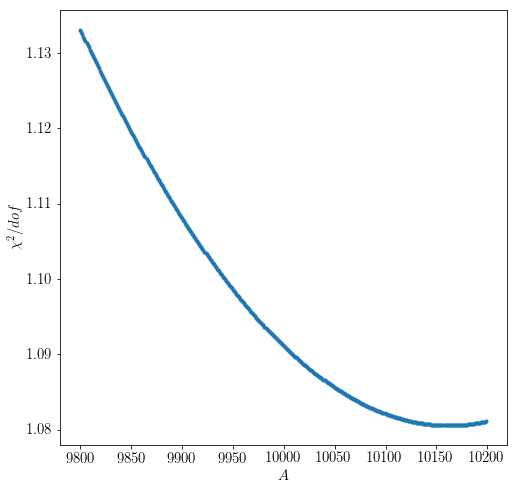

In [36]:
def psfPhot(image, Amin, Amax):
    """ Perform PSF photometry with a PSF=N(x=0,y=0,\sigma=sigmaNoise)"""
    # Estimate the noise in the image
    sigmaNoise = np.sqrt(image)

    # Subtract the background (we assume we've estimated it somehow)
    image = image - skyBg

    testA = np.arange(Amin, Amax)
    chi2dof = np.empty(testA.shape)
    best = (np.nan, np.inf)
    psf = makePSF(image.shape, 0, 0, sigmaPSF)
    for i, A in enumerate(testA):
        model = A*psf
        chi2 = np.sum(((image-model)/sigmaNoise)**2)
        chi2dof[i] = chi2 / (image.size - 1)
        if chi2dof[i] < best[1]:
            best = (A, chi2dof[i])
    return best, testA, chi2dof

image = simulatedImage

((bestA, bestChi2dof), testA, chi2dof) = psfPhot(image, Atrue - 200, Atrue + 200)
print ("A_ML = %.1f with chi^2/dof = %.2f" % (bestA, bestChi2dof))

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(testA, chi2dof, '.')
ax.set_xlabel(r"$A$")
ax.set_ylabel(r"$\chi^2/dof$")

phi = ((image - skyBg)*(makePSF(image.shape, 0, 0, sigmaPSF))/skyBg)
psi = ((makePSF(image.shape, 0, 0, sigmaPSF))**2/skyBg)
print(r'Analytically, A_ML =  %.1f' %(phi.sum()/psi.sum()))

## And we can also plot the likelihood instead

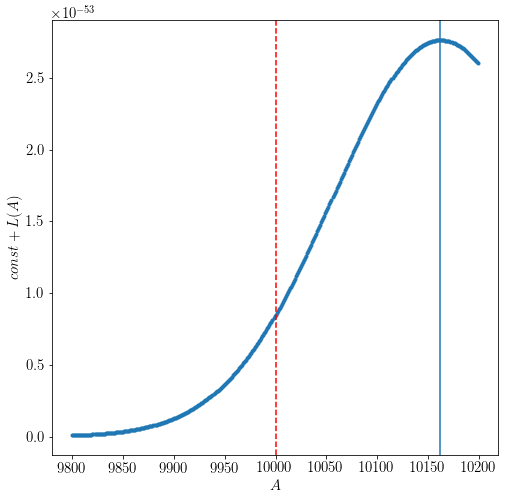

In [22]:
lnL = np.exp(-0.5*(chi2dof*(image.size-1)))

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(testA, lnL, '.')
ax.set_xlabel(r"$A$")
ax.set_ylabel(r"$const + L(A)$")

ax.axvline(x=bestA)
ax.axvline(x=Atrue, color='red', linestyle='--')

## Exercise 4: Calculate the maximum likelihood solution for the flux

Using the $\phi$ and $\psi$ formalism above estimate the PSF fulx using our MLE. For simplicity you can assume a constant noise and that you know the position of the star.


In [23]:

print ('The MLE estimator of the source flux is %g'%A)

NameError: name 'A' is not defined

## Models with more parameters

The iterative example above is a bit contrived as we can, and did, solve the MLE analytically

It has the benefit of being general, however. We can apply the same technique to models with more parameters (within the limits of computing power available to us!). The other parameters could be the position of the object ($x$, $y$), or some measure of the shape of the object.

As the number of parameters increases, the likelihood curve from the previous slide becomes the ***likelihood (hyper)surface***. The more dimensions there are, the more difficult (computationally expensive) it becomes to find its maximum using brute force solutions; even for 2D cases, we're likely to resort to ***minimization algorithms*** (e.g., Levenberg–Marquardt or others).

## Example 3: Measuring the size and brightness of a spherical, gaussian, galaxy

Let's explore a two-dimensional case.

Imagine that, instead of a star, we're observing a galaxy. Even in the ideal (space) case, the Galaxy will not be a point source. We'll imagine we're dealing with a "Gaussian spherical galaxy" -- i.e., one whose intensity  falls of as a 2D gaussian would. As with the star, we'll asume the position of the galaxy is known.

Our model has two parameters: the measure of the extendedness of the galaxy -- $\sigma$ -- and its total flux, $C$:

>$ I(x, y) = \frac{C}{2 \pi \sigma^2} \exp \left( -\frac{(x-x_0)^2 + (y-y_0)^2}{2\sigma^2} \right) $

Our code will now have to explore the likelihood surface in $(C, \sigma)$ space, and find the point of its maximum.

Note #2: When generating the simulated image, $I(x, y)$ needs to be ***convolved*** with the PSF. Fortunately (actually, on purpose!) we've chosen the galaxy profile to be gaussian, and the convolution of two gaussians with variances $\sigma_1^2$ and $\sigma_2^2$ is also a gaussian with the variance $\sigma_1^2 + \sigma_2^2$ (i.e., it's wider). Our function `gauss2D` utilizes this fact to generate the convolved image of the galaxy.

## Helper functions

Plotting functions

In [20]:
def FourPanelPlot(nonoise, psf, image, diffimage):
    """
        Make a 4-panel plot of the noiseless image, the psf, the image with noise, and the difference.
    """
    ## nonoise -- noiseless image, N x N array
    ## psf -- the image of the PSF, N x N array
    ## image -- image with the added noise, N x N array
    ## diffimage -- difference image (image - psf)

    fig = plt.figure(figsize=(8, 8))
    fig.subplots_adjust(left=0.13, bottom=0.15, right=0.95, top=0.90, wspace=0.18, hspace=0.46)

    images = [
        (221, nonoise, "noiseless image",  ['',          r' ',          r'y (pixels)']),
        (223, psf,     "psf image",        ['',          r'x (pixels)', r'y (pixels)']),
        (222, image,   "image with noise", [r'$counts$', r' ',          r'']),
        (224, diffimage, "image - psf",    [r'$counts$', r'x (pixels)', r''])
    ]

    for (loc, img, title, (clabel, xlabel, ylabel)) in images:
        plotCutout(img, title, clabel, xlabel, ylabel, loc, fig)

    #plt.savefig('4panels.png')

def plotLikelihood(chiPixSig, chiPixCmod, lnL, sigtrue, sigmaML, CmodML):
    """Plot the likelihood densities"""
    fig = plt.figure(figsize=(8, 8))
    fig.subplots_adjust(left=0.08, bottom=0.15, right=0.95, top=0.90, wspace=0.29, hspace=0.46)

    ## renormalize and truncate for clean plotting
    lnL -= lnL.max()
    lnL[lnL < -6] = -6

    ## lnL image 
    ax = fig.add_axes([0.35, 0.35, 0.45, 0.6], xticks=[], yticks=[])
    ax.set_title('ln(L) image', fontsize=14)
    # pretty color map
    plt.imshow(lnL, origin='lower', extent=(chiPixSig[0], chiPixSig[-1], chiPixCmod[0], \
                                            chiPixCmod[-1]), cmap=plt.cm.RdYlGn, aspect='auto')

    # colorbar
    cax = plt.axes([0.82, 0.35, 0.02, 0.6])
    cb = plt.colorbar(cax=cax)
    cb.set_label(r'$lnL(\sigma, C_{mod})$', fontsize=14)
    plt.clim(np.min(lnL), np.max(lnL))

    # contours
    # plt.contour(chiPixSig, chiPixCmod, convert_to_stdev(lnL), levels=(0.683, 0.955, 0.997), colors='w')

    # mark true values     
    ax.plot(sigtrue, 1000.0, 'o', color='red', alpha=0.75)
    # mark ML solution: (sigmaML, CmodML)
    ax.plot(sigmaML, CmodML, 'x', color='white', alpha=0.99, lw=35)

    # marginal projections
    p_sigma = np.exp(lnL).sum(0)
    p_Cmod = np.exp(lnL).sum(1)
  
    ax1 = fig.add_axes([0.35, 0.1, 0.45, 0.23], yticks=[])
    ax1.plot(chiPixSig, p_sigma, '-k')
    ax1.set_xlabel(r'$\sigma$ (pixel)', fontsize=12)
    ax1.set_ylabel(r'$p(\sigma)$', fontsize=12)
    ax1.set_xlim(np.min(chiPixSig), np.max(chiPixSig))

    ax2 = fig.add_axes([0.15, 0.35, 0.18, 0.6], xticks=[])
    ax2.plot(p_Cmod, chiPixCmod, '-k')
    ax2.set_ylabel(r'$C_{mod}$ (counts)', fontsize=12)
    ax2.set_xlabel(r'$p(C_{mod})$', fontsize=12)
    ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse x axis
    ax2.set_ylim(np.min(chiPixCmod), np.max(chiPixCmod))

Functions that simulate the image, and compute the likelihood surfaces

In [21]:
### computations 
def gauss2D(muX, muY, sig, A, skyBg, sigPSF, Xpixels, Ypixels):
    """
    Generate an image of size (Xpixels, Ypixels) with
    a 2D circular Gaussian of total flux A
    with standard deviation sigma^2=sig^2 + sigPSF^2
    superimposed on a uniform background B and centered
    on (muX, muY).
    """
    r = np.sqrt((Xpixels-muX)**2 + (Ypixels-muY)**2)
    # make and set image to the background value
    image = np.empty(r.shape)
    image.fill(skyBg)

    ## now add circular gaussian profile (normalized to A)
    # source gauss convolved with single-gauss PSF  
    sigConvSquare = sig**2 + sigPSF**2
    image += A*np.exp(-r**2/2/sigConvSquare) / (2*math.pi*sigConvSquare)
    return image


def addnoise(inimage, sigNoise, sourceImage, addsourcenoise=0): 
    """Add gaussian noise to the image, and return the image and variance plane"""
    image = np.copy(inimage)
    image += np.random.normal(0, sigNoise, image.shape)
    variance = 0*image + sigNoise**2

    if (addsourcenoise):
        gain = 1.0  # as a reminder...
        sourceVariance = sourceImage/gain
        image += np.random.normal(0, np.sqrt(sourceVariance), image.shape)
        variance += sourceVariance

    return image, variance 


### make chi2(sigma, Cmod) image, find the ML solution, and return the best-fit model image 
def getlnLimage(xpix, image, muX, muY, skyBg, sigmaPSF, sigmaNoise): 
    """
    Compute the log-likelihood image.
    """

    # a little helper 
    def lnLinit(yPixels, xPixels):
        lnL = np.zeros(xPixels.shape, dtype=float) - 0 * np.log(yPixels)
        return lnL

    ## first make the log likelihood (lnL) image
    # define the grid
    chiPixelsSigma = np.linspace(0, 2.5, 101)
    chiPixelsCmod = np.linspace(500, 1500, 101)
    lnL = lnLinit(chiPixelsCmod[:, None], chiPixelsSigma)

    # brute force loop over all sigma and Cmod
    chi2min = np.inf
    sigmaML = -1.0
    CmodML = -1.0
    for i in range(0, chiPixelsSigma.size):
        sigma = chiPixelsSigma[i]
        for j in range(0,chiPixelsCmod.size):
            Cmod = chiPixelsCmod[j]
            # model image: a circular 2D gaussian 
            model = gauss2D(muX, muY, sigma, Cmod, skyBg, sigmaPSF, xpix[:, np.newaxis], xpix)
            thisChi2 = np.sum(((image-model)/sigmaNoise)**2)
            lnL[j][i] = thisChi2   # NB this is chi2, not yet lnL (see below)
            if (thisChi2 < chi2min): 
                chi2min = thisChi2
                sigmaML = sigma
                CmodML = Cmod
                
    ## go from chi2 to ln(L) 
    # since L = exp(-chi2/2): lnL = -1/2 * chi2
    lnL = -0.5*lnL
            
    # ML model
    bestModel = gauss2D(muX, muY, sigmaML, CmodML, skyBg, sigmaPSF, xpix[:, np.newaxis], xpix)
    # chi2 per degree of freedom
    chi2minDOF = chi2min / (xpix.size**2 - 2)
    return chiPixelsSigma, chiPixelsCmod, lnL, bestModel, sigmaML, CmodML, chi2minDOF

Driver functions

In [22]:
def simulate(muXtrue, muYtrue, sigtrue, Atrue, skyBg, sigmaPSF, sigmaNoise, seed=42):
    # set seed
    np.random.seed(seed)
    
    # define the (square) grid
    xpix = np.linspace(-7, 7, 15)

    ## make psf (sigtrue=0) 
    psf = gauss2D(muXtrue, muYtrue, 0, Atrue, skyBg, sigmaPSF, xpix[:, np.newaxis], xpix)

    ## make noiseless image (convolved with psf given by sigmaPSF, image size given by 1Dpixels) 
    nonoise = gauss2D(muXtrue, muYtrue, sigtrue, Atrue, skyBg, sigmaPSF, xpix[:, np.newaxis], xpix)
 
    ## now add noise
    image, variance = addnoise(nonoise, sigmaNoise, 0) 

    ## difference object - psf
    diffimage = image - psf

    return nonoise, psf, image, diffimage

def printMLResults(sigmaML, CmodML, chi2minDOF, bestModel, image, psf):
    print ('the Maximum Likelihood point:')    
    print ('sigmaML = ', sigmaML)
    print (' CmodML = ', CmodML)
    print ('chi2DOF = ', chi2minDOF)

    ## compute Cmod from bestModel and compare to CmodML
    modelNorm = bestModel / np.sum(bestModel)
    wModel = modelNorm / np.sum(modelNorm**2)
    CountModel = np.sum(image*wModel)
    print ('Cmod from bestModel profile: ', CountModel)

    ## compute Cpsf from the PSF profile 
    psfNorm = psf / np.sum(psf)
    wPSF = psfNorm / np.sum(psfNorm**2)
    CountPSF = np.sum(image*wPSF)
    print ('Cpsf from the PSF profile: ', CountPSF)

def demo(muXtrue, muYtrue, sigtrue, Atrue, skyBg, sigmaPSF, sigmaNoise, seed=42):
    # define the (square) grid
    xpix = np.linspace(-7, 7, 15)

    nonoise, psf, image, diffimage = simulate(muXtrue, muYtrue, sigtrue, Atrue, skyBg, sigmaPSF, sigmaNoise, seed)
    chiPixSig, chiPixCmod, lnLimage, bestModel, sigmaML, CmodML, chi2minDOF = getlnLimage(xpix, image, muXtrue, muYtrue, skyBg, sigmaPSF, sigmaNoise)

    # visualize results
    FourPanelPlot(nonoise, psf, image, diffimage)
    printMLResults(sigmaML, CmodML, chi2minDOF, bestModel, image, psf)
    plotLikelihood(chiPixSig, chiPixCmod, lnLimage, sigtrue, sigmaML, CmodML)

    return xpix, nonoise, psf, image, diffimage


## Sanity check: a star

the Maximum Likelihood point:
sigmaML =  0.0
 CmodML =  1010.0
chi2DOF =  0.944291679508
Cmod from bestModel profile:  6621.8036442
Cpsf from the PSF profile:  6629.48567646


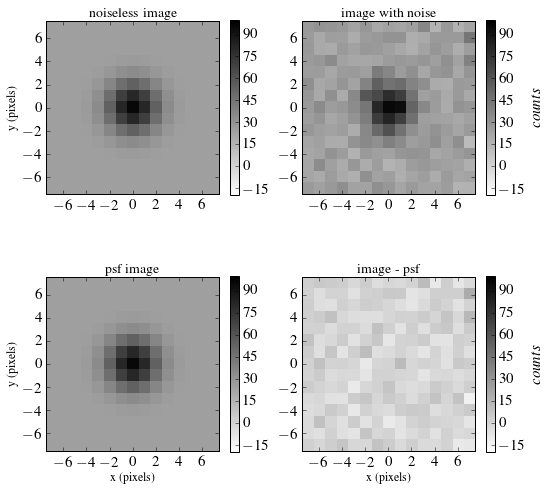

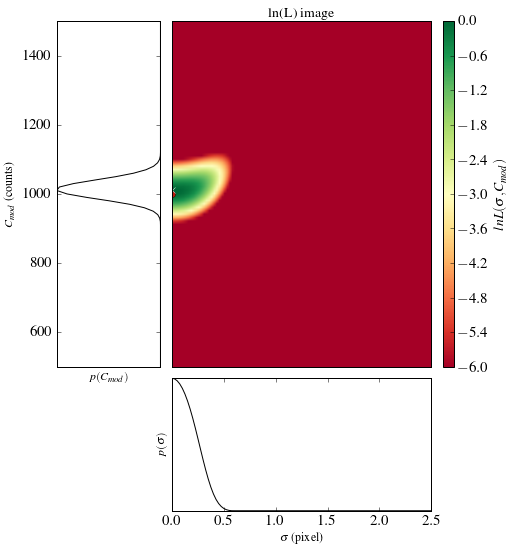

In [23]:
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid 
sigmaNoise = 5.0  # gaussian sigma for white noise (counts), e.g. due to sky 
sigtrue = 0.0     # the intrinsic gaussian source width, sigma (in pixels) 
Ctrue = 1000.0    # the source count normalization
skyBg = 25        # sky background

demo(muXtrue, muYtrue, sigtrue, Ctrue, skyBg, sigmaPSF, sigmaNoise);

the Maximum Likelihood point:
sigmaML =  0.9
 CmodML =  970.0
chi2DOF =  0.939255229631
Cmod from bestModel profile:  6617.82108974
Cpsf from the PSF profile:  6440.93837768


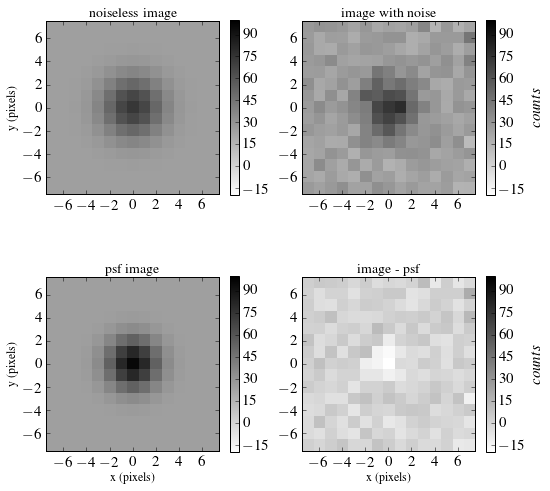

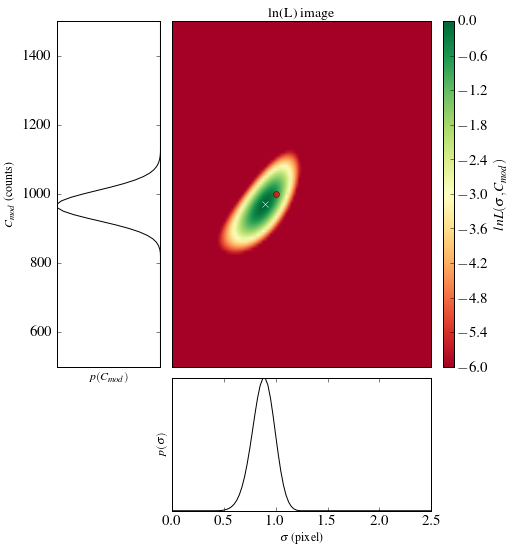

In [24]:
sigtrue = 1.0     # the intrinsic gaussian source width, sigma (in pixels) 
demo(muXtrue, muYtrue, sigtrue, Ctrue, skyBg, sigmaPSF, sigmaNoise);

## Summary

ML estimators are the standard workhorse for estimation of parameter values all across astronomy. Today we've seen how they can be used to perform stellar PSF photometry and shape measurement of objects. We've also learned a bit about image processing in astronomy.

Though the details may be more complicated, ***what you've seen today is very similar in spirit to what LSST DM image processing codes do today***.

For more on this topic, read "Photon Rates and SNR Calculations" by Ivezic, Jones & Lupton (http://ls.st/lse-40; especially Section 4).